# Предсказание рейтинга ресторана по данным сайта Tripadvisor
TripAdvisor — крупнейшая в мире платформа о путешествиях. Даёт своим пользователям возможность спланировать поездку в любую страну мира. На сайте можно посмотреть фотографии, рейтинги и узнать базовую информацию о местах. Нас будет инетресовать, где можно вкусно поесть :)

Есть **проблема**:  нечестные рестораны, которые накручивают себе рейтинг. Одним из способов нахождения таких ресторанов является построение модели, которая предсказывает рейтинг ресторана. Если предсказания модели сильно отличаются от фактического результата, то, возможно, ресторан играет нечестно, и его стоит проверить.

In [2]:
import pandas as pd
import math
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

from IPython.display import Image
from IPython.core.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

%matplotlib inline
plt.style.use('ggplot')

In [3]:
def categorical_data(col):
    plt.figure(figsize=(7, 7))
    data_toplot = data[col].value_counts(normalize=True).sort_index()
    graph = sns.countplot(data[col], order=data_toplot.index)
    ax = graph.axes
    for bar, value in zip(ax.patches, data_toplot):
        x_text = bar.get_x() + bar.get_width() / 2
        y_text = bar.get_height()
        ax.annotate('{}%'.format(round(100 * value, 2)), (x_text, y_text), ha='center', va='center',
                    fontsize=11, color='black', rotation=0, xytext=(0, 10), textcoords='offset points')
    plt.title('Histogram for ' + col)
    plt.show()


def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='Rating',
                data=data,
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [4]:
data = pd.read_csv('main_task.csv')  # загружаем данные

## Первичный осмотр данных
Датасет, содержит сведения о 40 000 ресторанах Европы. **Задача:** обучить модель, которая будет предсказывать рейтинг ресторана на основе имеющихся в датасете данных.

### Начальные признаки:
* Restaurant_id — идентификационный номер ресторана / сети ресторанов;
* City — город, в котором находится ресторан;
* Cuisine Style — кухня или кухни + "стиль" еды, к которым можно отнести блюда, предлагаемые в ресторане;
* Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
* Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
* Price Range — диапазон цен в ресторане;
* Number of Reviews — количество отзывов о ресторане;
* Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
* URL_TA — URL страницы ресторана на TripAdvisor;
* ID_TA — идентификатор ресторана в базе данных TripAdvisor.

In [9]:
data.info()  # смотрим на типы данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 2.0+ MB


In [10]:
data.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


## Пропуски

In [11]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()
           ).sort_values(ascending=False)
missing_data = pd.concat([total, percent],
                         axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
Price Range,13886,0.347150
Cuisine Style,9283,0.232075
Number of Reviews,2543,0.063575
ID_TA,0,0.000000
URL_TA,0,0.000000
Reviews,0,0.000000
Rating,0,0.000000
Ranking,0,0.000000
City,0,0.000000
Restaurant_id,0,0.000000


Осмотрев датасет в общем, просмотрю каждую колонку отдельно. По дороге буду заполнять пропуски, кое-где менять формат представления данных и добавлять новые признаки.

## Rating - целевая переменная

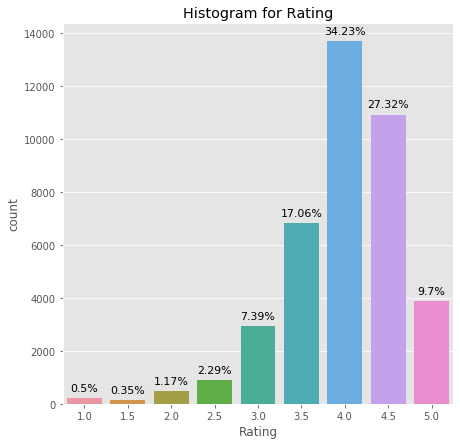

In [12]:
categorical_data('Rating')

Очевидных выбросов/ошибок нет, по форме похоже на смещённое влево нормальное распределение.

## Restaurant_id

Restaurant_id - это идентификационной номер ресторана, причём рестораны одной сети имеют одинаковы id. Б*о*льшая доля приходится на несетевые заведения, однако встречаются рестораны с довольно большим количеством работающих точек.

In [15]:
print('Уникальных id: {0}\nВсего ресторанов в датасете: {1}'.
      format(data['Restaurant_id'].nunique(), len(data)))
rest_id = data['Restaurant_id'].value_counts()
total = rest_id.value_counts()
percent = rest_id.value_counts(normalize=True)

rest_chain = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
rest_chain.index.name = 'Число ресторанов в сети'
rest_chain

Уникальных id: 11909
Всего ресторанов в датасете: 40000


,Total,Percent
Число ресторанов в сети,,
1,4705,0.395079
2,2317,0.194559
3,1226,0.102947
4,812,0.068184
5,514,0.043161
6,413,0.034680
7,384,0.032245
9,332,0.027878
8,311,0.026115


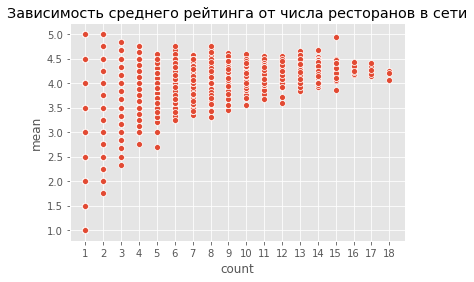

In [16]:
# число ресторанов в сети vs средний рейтинг
df_gr = data.groupby('Restaurant_id')['Rating'].agg(['mean', 'count'])
sns.scatterplot(x='count', y='mean', data=df_gr)
plt.title('Зависимость среднего рейтинга от числа ресторанов в сети')
plt.xticks(range(1, 19));

Здесь видно, что разброс среднего рейтинга уменьшается с увеличением числа ресторанов в сети. Это можно объяснить с одной стороны уменьшением числа наблюдений с увеличением числа ресторанов в сети (1 ресторан - ~4700 наблюдений, 18 - 4 наблюдения, см. таблицу выше), с другой - тем, что сетевые рестораны имеют более жёсткие стандарты качества, поэтому более стабильный (хороший, но не отличный) рейтинг.

## City
Город, в котором находится ресторан.

Всего городов: 31


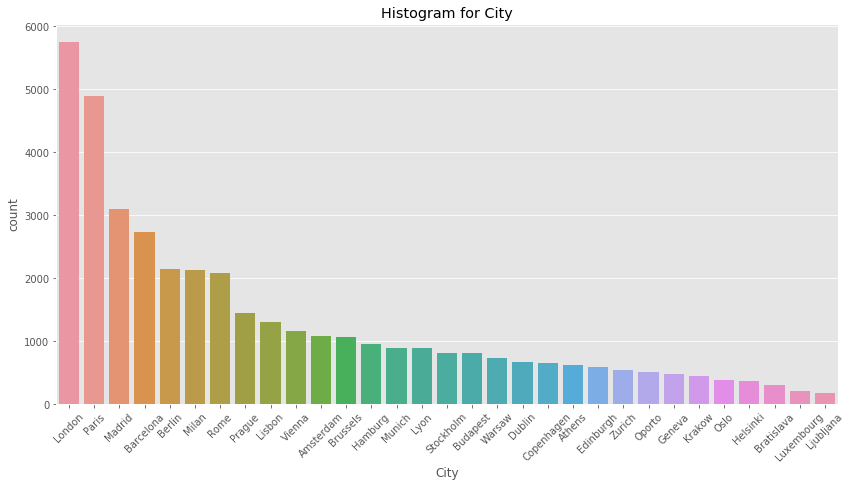

In [22]:
print('Всего городов: {}'.format(data['City'].nunique()))
plt.figure(figsize=(14, 7))
chart = sns.countplot(
    data['City'], order=data['City'].value_counts(ascending=False).index)
plt.title('Histogram for City')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

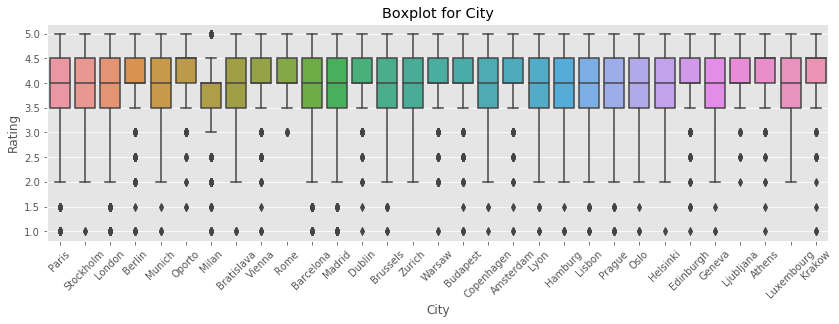

In [23]:
get_boxplot('City')

Многие города имеют визуально одинаковый разброс по рейтингу. Однако дальше оказалось, что модель предсказывает целевую переменную точнее, если включить в виде dummy-переменных все города.

In [24]:
data = pd.get_dummies(data, columns=['City'])

## Cuisine Style 
Кухня или "стиль" кухни, к которым можно отнести ресторан.

In [26]:
data['Cuisine Style'].iloc[:5]

0              ['European', 'French', 'International']
1                                                  NaN
2    ['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...
3                                                  NaN
4    ['German', 'Central European', 'Vegetarian Fri...
Name: Cuisine Style, dtype: object

Так как пропущенных значений довольно много (~20%), имеет смысл выделить отдельную категорию "значение не определено".

In [27]:
data['Cuisine Style'].fillna('[not defined]', inplace=True)

Данные типа 'object', преобразую построчно в тип 'list', а затем посмотрю число уникальных элементов и наиболее часто встречающиеся значения.

Уникальных значений: 126


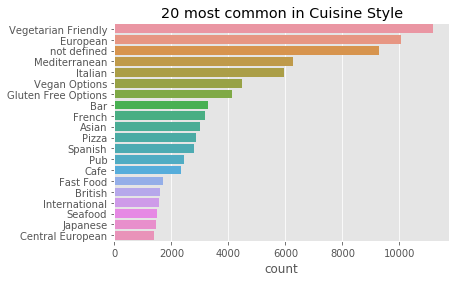

In [82]:
style_ls = []
for row in data['Cuisine Style'].dropna().apply(lambda x: x[1:-1].replace("'", "").split(', ')):
    style_ls.extend(row)
print('Уникальных значений: {}'.format(len(Counter(style_ls))))
labels = [item[0] for item in Counter(style_ls).most_common(20)]
number = [item[1] for item in Counter(style_ls).most_common(20)]
sns.barplot(number, labels, orient='h')
plt.xlabel('count')
plt.title('20 most common in Cuisine Style');

In [30]:
# сколько типов\стилей кухни представлено в ресторане
# если было пустое, ставим 1

style = data['Cuisine Style'].apply(
    lambda x: x[1:-1].replace("'", "").split(', ') if x != 'not defined' else '')
style_ls = []
for row in style:
    style_ls.extend(row)

# новый признак: сколько стилей кухни в ресторане
data['num_cuisine_style'] = style.apply(lambda x: len(x) if x != '' else 1)

In [31]:
# dummy для 25 популярных стилей

styles = [item[0] for item in Counter(style_ls).most_common(25)]

for style in styles:
    data['style_' +
         style] = data['Cuisine Style'].apply(lambda x: 1 if style in x else 0)

## Ranking
Место, которое занимает данный ресторан среди всех ресторанов *своего* города.

count    40000.000000
mean      3676.028525
std       3708.749567
min          1.000000
25%        973.000000
50%       2285.000000
75%       5260.000000
max      16444.000000
Name: Ranking, dtype: float64

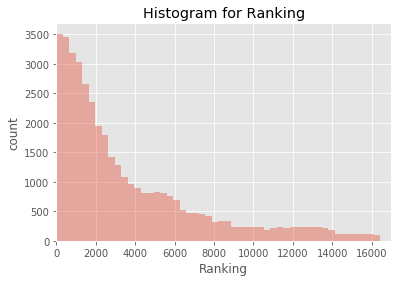

In [17]:
# проверка на нецелые значения, их нет
data['Ranking'].apply(lambda x: x.is_integer()).value_counts()
sns.distplot(data['Ranking'], kde=False)
plt.title('Histogram for Ranking')
plt.ylabel('count')
plt.xlim(0, 17000)
data['Ranking'].describe()

Очевидных выбросов в столбце не видно, но настораживают максимальные значения. Больше 10К ресторанов в городе - многовато. Посмотрю на города, в которых встречаются рестораны с таким низким "внутренним" рейтингом.

In [18]:
data.query('Ranking>10000')['City'].value_counts()

London    2219
Paris     1350
Name: City, dtype: int64

Так становится понятнее. По статистике в [Лондоне](https://www.statista.com/statistics/298871/number-of-restaurants-in-the-united-kingdom/) работает около 88K точек питания, а в [Парижском регионе](https://www.francebleu.fr/infos/economie-social/le-boom-des-cafes-en-ile-de-france-1484762633) чуть меньше 40K.

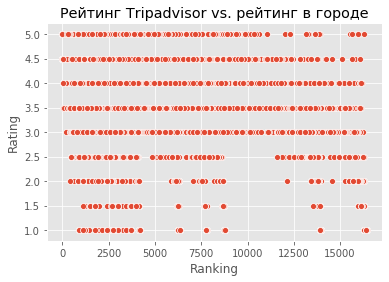

In [20]:
sns.scatterplot(x='Ranking', y='Rating', data=data)
plt.title('Рейтинг Tripadvisor vs. рейтинг в городе');

Уф, по рейтингу 3-5 баллов размазаны рестораны с самыми разными рейтингами внутри городов. Пустой левый нижний угол интуитивно понятен: первые места в городе не занимают рестораны с совсем низким рейтингом в 1-2.5 балла. Ещё есть пустота в районе того же низкого рейтинга на Tripadvisor и ниже среднего рейтинга внутри города, смысл которой не очевиден.

## Price_range
Признак содержит три категории: недорого, умеренная цена, ресторан высокой кухни.

In [32]:
def price_range_name(x):
    # меняю названия категорий для дальнейшего удобства
    if x == '$':
        return 'cheap'
    if x == '$$ - $$$':
        return 'mid-range'
    if x == '$$$$':
        return 'fine dining'


data['Price Range'] = data['Price Range'].apply(price_range_name)

Признак содержит около 35% пропусков, имеет смысл выделить отдельную категорию "не определено".

In [33]:
data['Price Range'].fillna('not defined', inplace=True)

In [34]:
data['Price Range'].value_counts(normalize=True)

mid-range      0.460300
not defined    0.347150
cheap          0.156975
fine dining    0.035575
Name: Price Range, dtype: float64

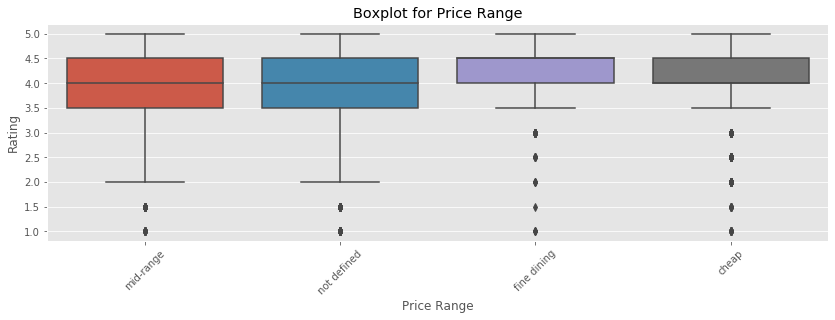

In [35]:
get_boxplot('Price Range')

Неожиданно, что рестораны из категорий "недорого" и "высокая кухня" имеют одинаковые разбросы значений по рейтингу и одинаковый средний рейтинг (видно по одинаковым боксплотам).

'Price Range' тоже преобразую в dummy-переменные.

In [36]:
data = pd.get_dummies(data, columns=['Price Range'])

## Number of reviews
Количество отзывов о ресторане.

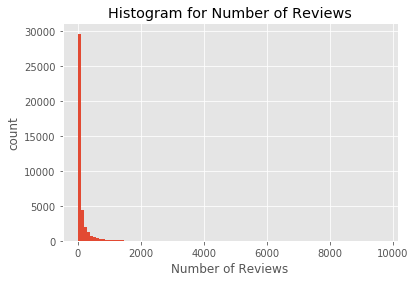

In [81]:
data['Number of Reviews'].dropna().apply(lambda x: x.is_integer()
                                         ).value_counts()  # проверка на нецелые значения, их нет

data['Number of Reviews'].hist(bins=100)
data['Number of Reviews'].describe()
plt.ylabel('count')
plt.xlabel('Number of Reviews')
plt.title('Histogram for Number of Reviews');

Очевидных выбросов нет, но смущает разброс значений. Возможно имеет смысл удалить экстремально большие, чтобы избежать проблем в построении модели.

Верхняя граница выбросов: 245.625 отзывов
Потенциальных выбросов: 4888


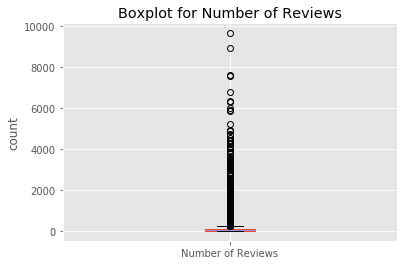

In [79]:
perc25 = data['Number of Reviews'].quantile(0.25)
perc75 = data['Number of Reviews'].quantile(0.75)
upper_bound = perc75 + 1.5*(perc75 - perc25)
print('Верхняя граница выбросов: {0} отзывов\nПотенциальных выбросов: {1}'
      .format(upper_bound, len(data['Number of Reviews'][data['Number of Reviews'] > upper_bound])))
data.boxplot(column='Number of Reviews')
plt.ylabel('count')
plt.title('Boxplot for Number of Reviews');

Детекция выбросов по межквартильному размаху не подходит, так как придётся удалить слишком много значений. Нужен другой метод.

Дальше оказывается, что этот признак очень слабо коррелирует с целевой переменной (~0.027), поэтому оставлю как есть.

Пропуски оптимально заполнить *медианой*, поскольку распределение признака сильно смещено вправо, значит среднее не отражает типичное наблюдение.

In [41]:
data['Number of Reviews'].fillna(
    data['Number of Reviews'].median(), inplace=True)

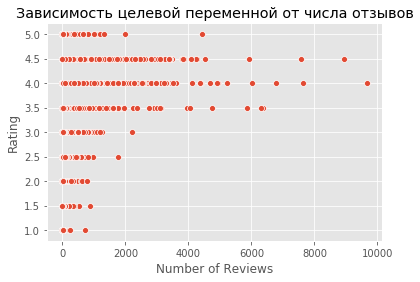

In [43]:
sns.scatterplot(x='Number of Reviews', y='Rating', data=data)
plt.title('Зависимость целевой переменной от числа отзывов');

Интересно, что максимально большое количество отзывов имеют места с рейтингом выше среднего (3.5-4.5), но не максимальным. Может быть это связано с тем, что рестораны с высшим рейтингом являются местами не для широкой публики и там просто меньше проходимость, а значит меньше отывов.

## Reviews
Данные о двух отзывах, которые показываются на сайте.

In [44]:
# как выглядят данные в колонке
print(data['Reviews'].iloc[0])  # два отзыва
print(data['Reviews'].iloc[16])  # один отзыв
print(data['Reviews'].iloc[3])  # пустая строка

[['Good food at your doorstep', 'A good hotel restaurant'], ['12/31/2017', '11/20/2017']]
[['This is a real hidden Sushi-gem'], ['04/12/2017']]
[[], []]


В колонке встречается три формата данных "отзыв + дата": пустая строка, один отзыв + одна дата, два отзыва + две даты. 

Достану даты первого ('1stRevDate') и второго отзывов ('2ndRevDate'). Пустые ячейки заменю на NaN, чтобы видеть реальную ситуацию по пропущенным значениям в датасете.

,1stRevDate,2ndRevDate
count,33529,28973
unique,1880,1951
top,2018-01-07 00:00:00,2018-01-03 00:00:00
freq,486,194
first,2004-04-21 00:00:00,2007-11-14 00:00:00
last,2018-02-26 00:00:00,2018-02-26 00:00:00


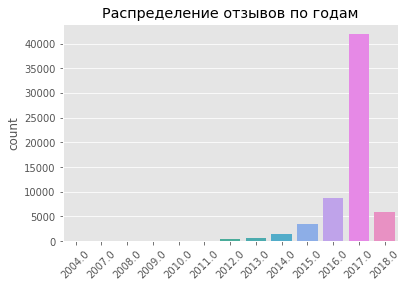

In [45]:
def datecolRev(x, idx):
    # in: x - str, idx - number of dates (1 or 2) in str
    # out: date

    # 0 элементов <> пустая ячейка
    # 10 элементов <> один отзыв
    # 22 элемента <> два отзыва

    if len(x) == 0:
        return np.nan
    if len(x) == 10:
        if idx == 0:
            return x.split(", ")[0]
        if idx == 1:
            return np.nan
    if len(x) == 22:
        return x.split(", ")[idx]


dates = data['Reviews'].dropna().apply(
    lambda x: x[2:-2].replace("'", "").split('], [')[1])
data['1stRevDate'] = dates.apply(datecolRev, args=(0,))
data['2ndRevDate'] = dates.apply(datecolRev, args=(1,))
data['1stRevDate'] = pd.to_datetime(data['1stRevDate'], errors='coerce')
data['2ndRevDate'] = pd.to_datetime(data['2ndRevDate'], errors='coerce')

chart = sns.countplot(
    pd.concat([data['1stRevDate'], data['2ndRevDate']], ignore_index=True).dt.year)
plt.title('Распределение отзывов по годам')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
data[['1stRevDate', '2ndRevDate']].describe()

Б*о*льшая часть отзывов была оставлена в 2017 году.

Теперь попробую извлечь информацию из самих отзывов. Возьму 30 самых популярных слов длиннее одного символа и создам по ним dummy-переменные.

In [46]:
reviews_series = data['Reviews'].apply(
    lambda x: x[2:-2].replace("'", "").split('], [')[0])

words_list = []
num_rev = []
for row in reviews_series:
    num_rev.append(len(row.split(', ')))
    for rev in row.split(', '):
        if rev == '':
            continue
        else:
            words_list.extend(rev.split(' '))

top_words = [item[0]
             for item in Counter(words_list).most_common(40) if len(item[0]) > 1]
for word in top_words:
    data['reviews_word_' +
         word] = reviews_series.apply(lambda x: 1 if word in x else 0)

Признак 'Reviews' содержит три формата данных (пустая строка, один или два отзыва). Добавлю колонку с информацией о количестве отзывов, отображающихся на сайте.

In [47]:
# новый признак: число отзывов, показывающихся на сайте (0, 1 or 2)

def num_rev_showed(x):
    if x == '':
        return 0
    else:
        return len(re.split(r"', '", x))


data['num_rev_showed'] = reviews_series.apply(num_rev_showed)

И сразу попытаюсь оценить значимость слов в отзывах визуально с помощью боксплотов. Метод очень грубый, но пока остановлюсь на нём.

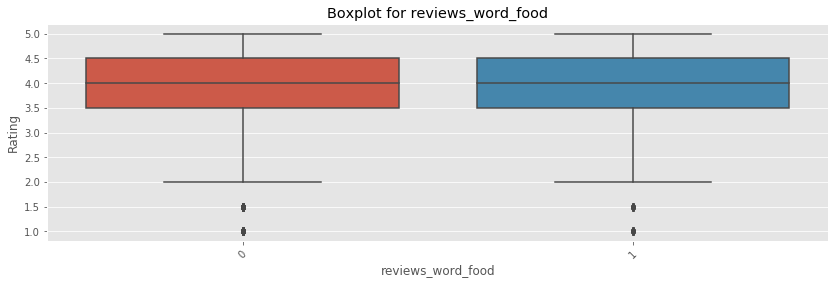

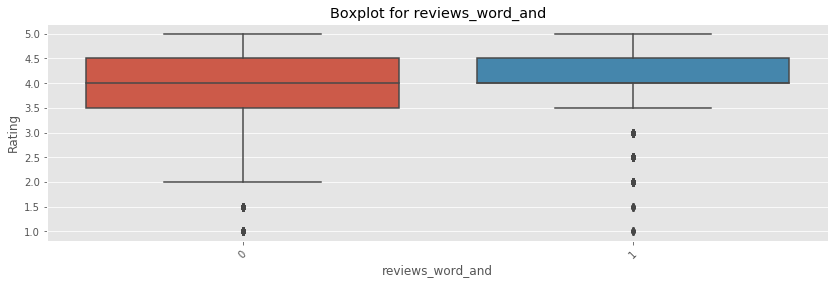

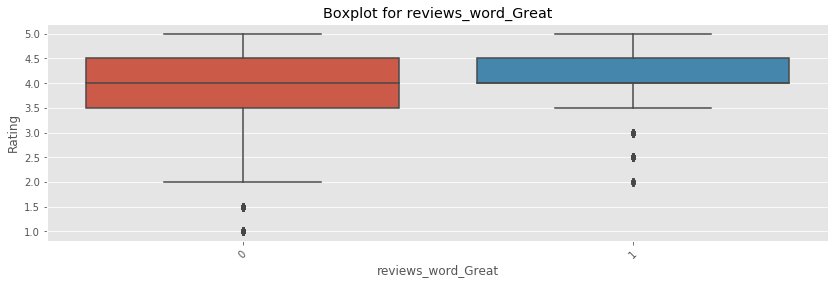

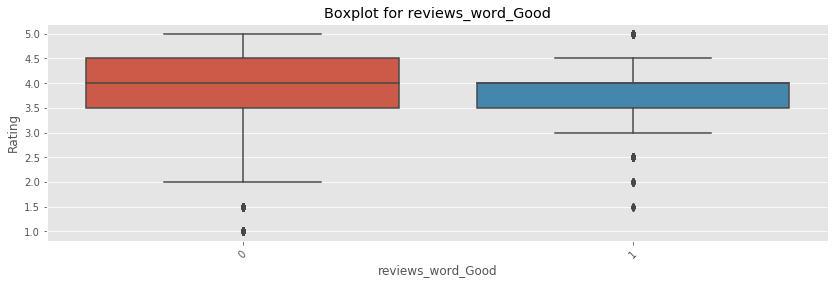

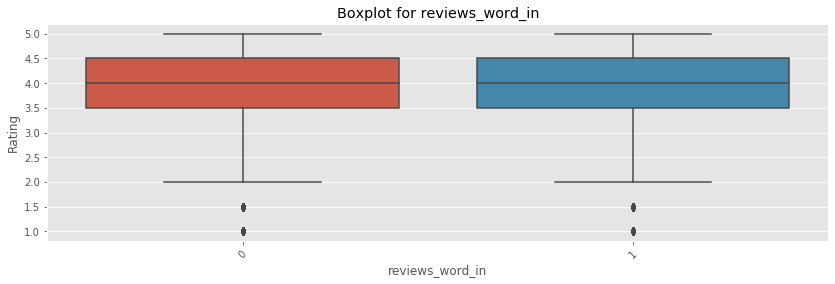

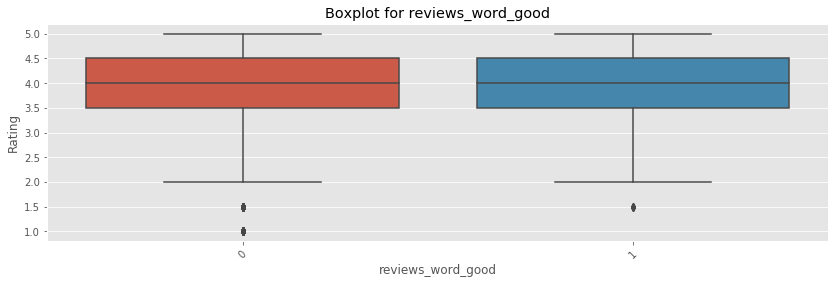

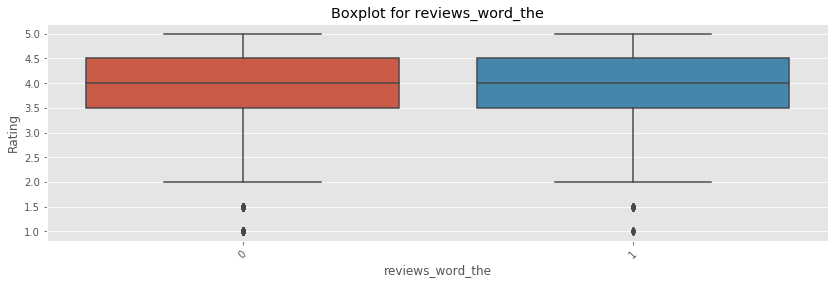

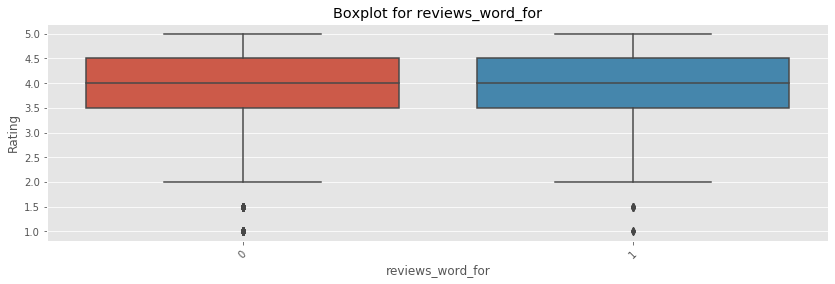

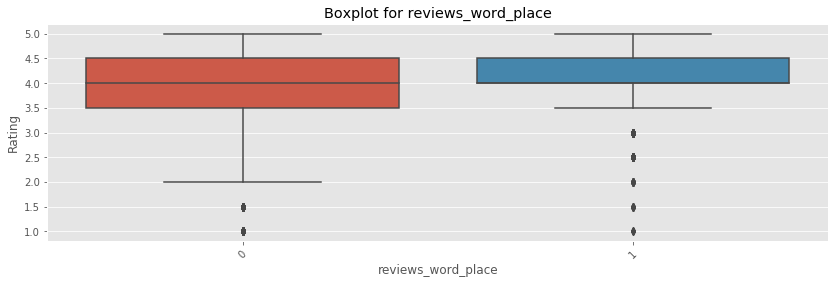

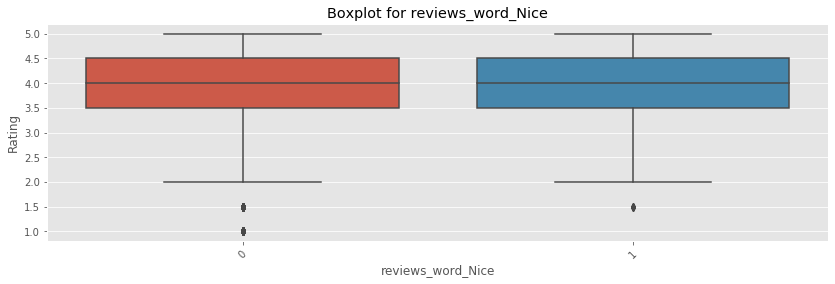

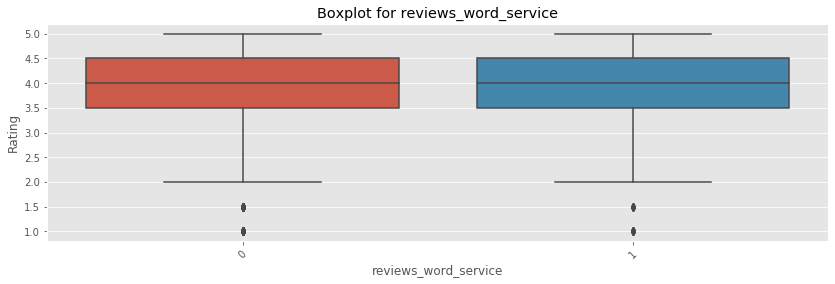

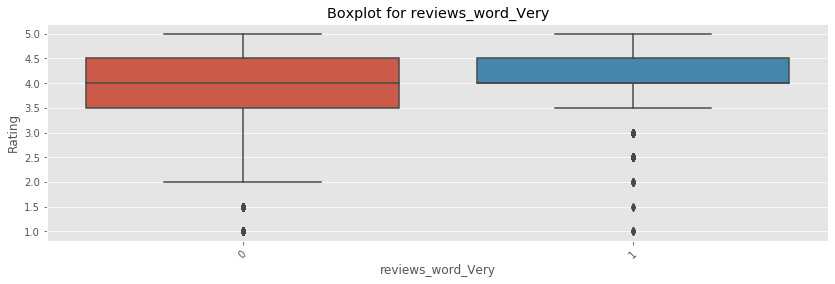

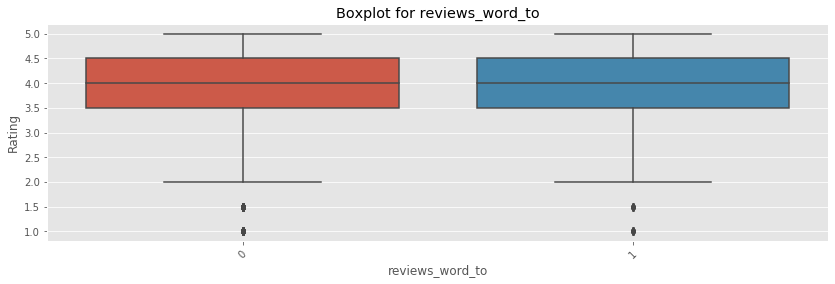

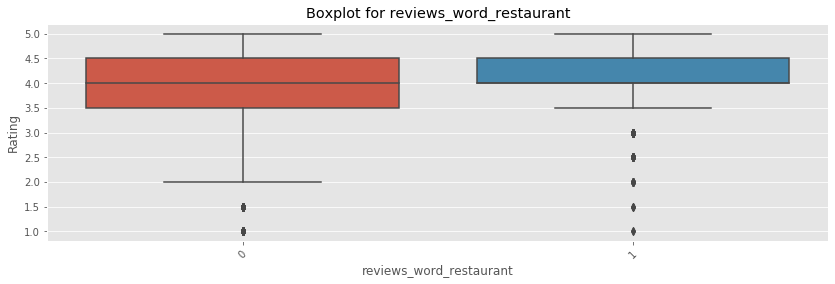

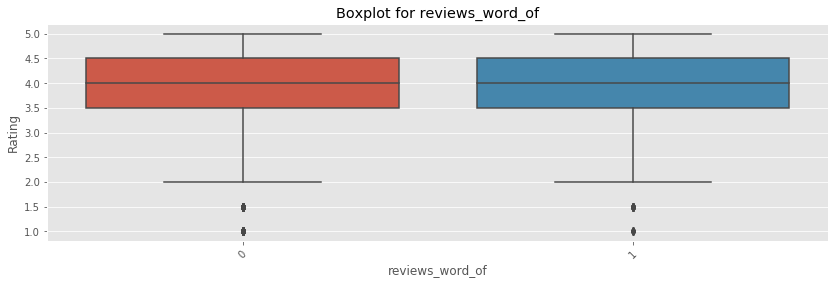

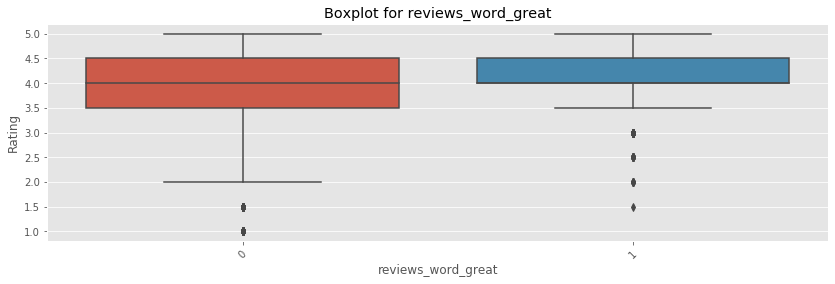

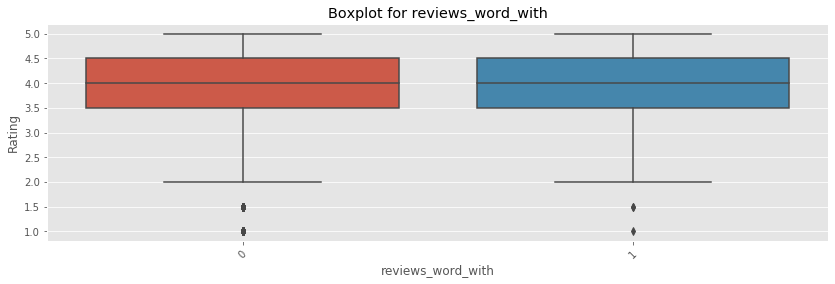

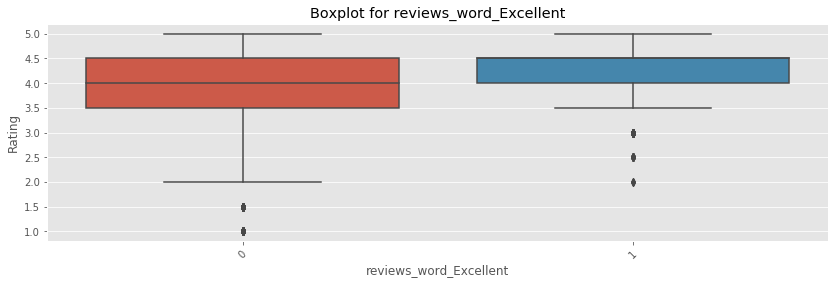

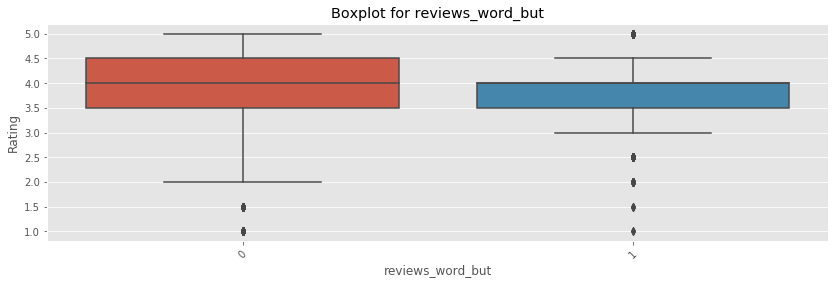

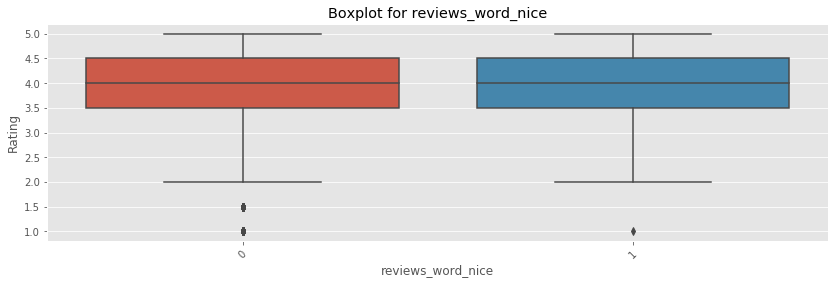

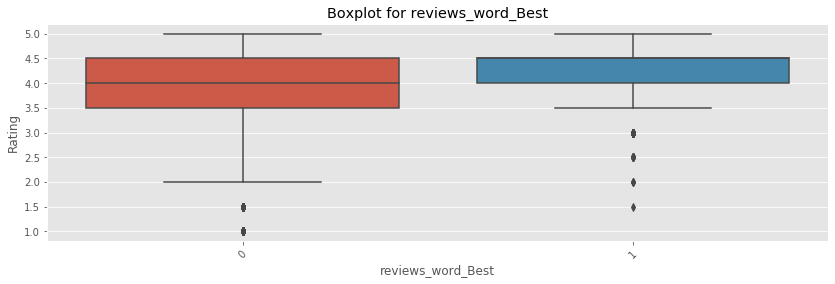

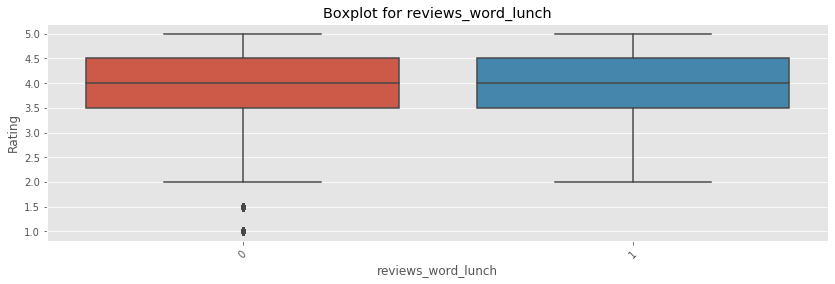

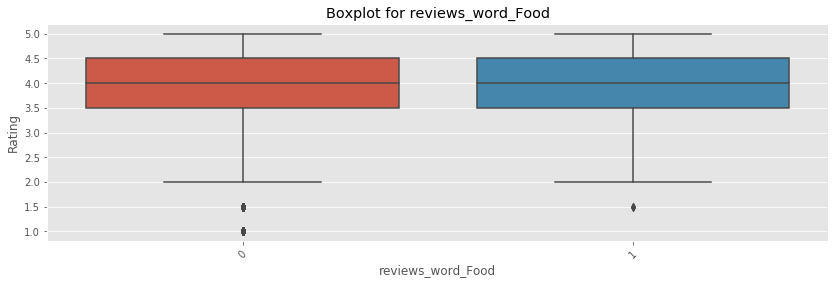

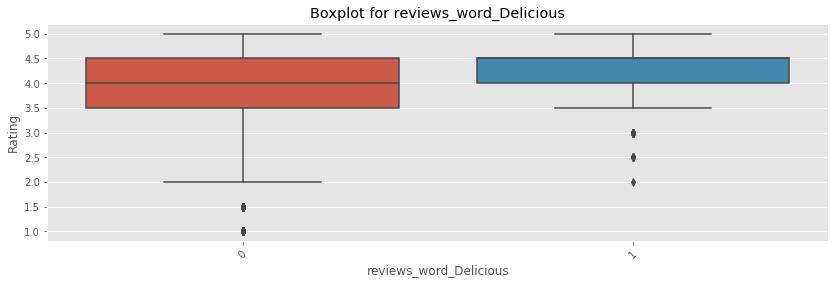

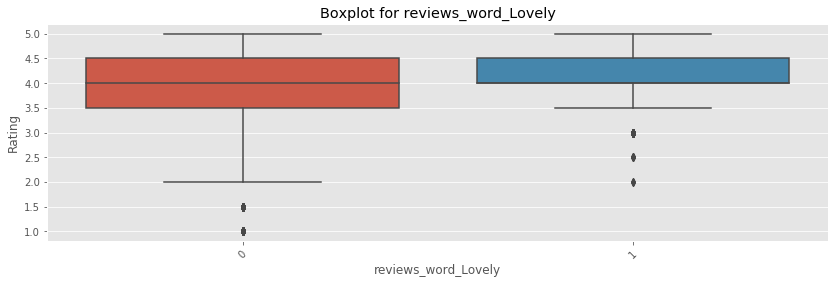

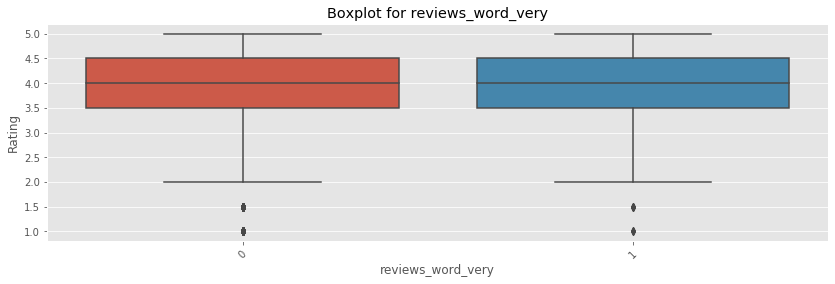

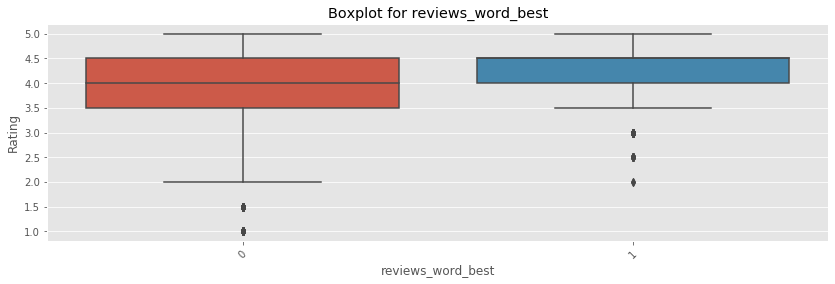

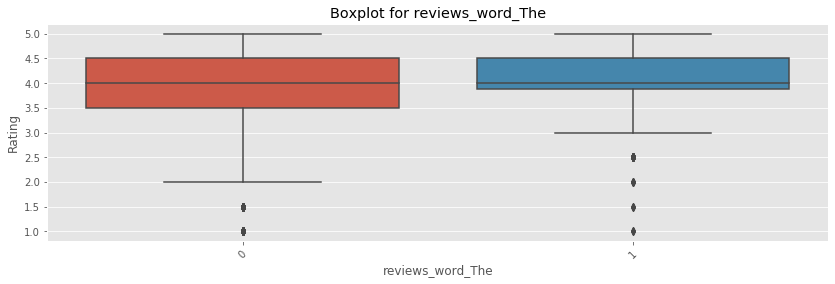

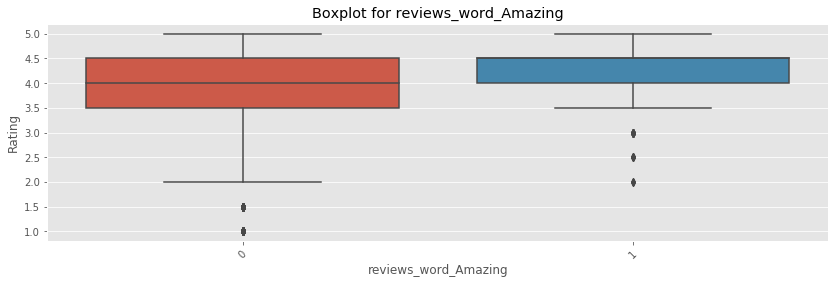

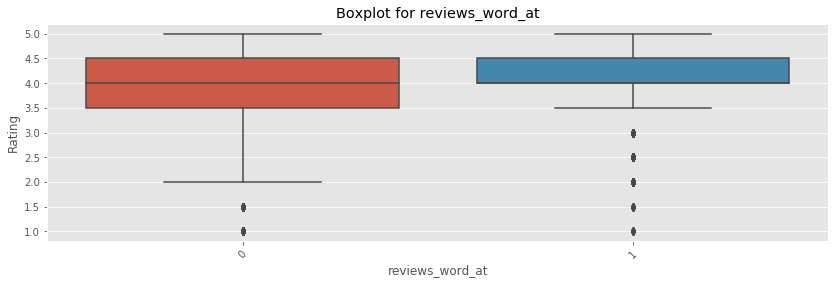

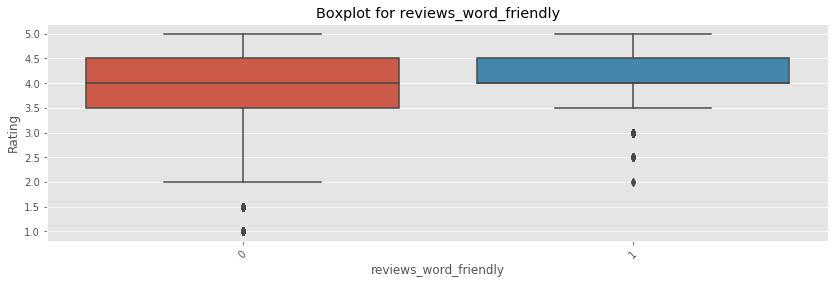

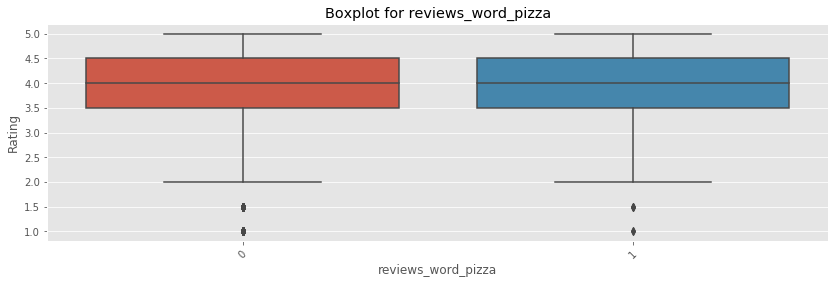

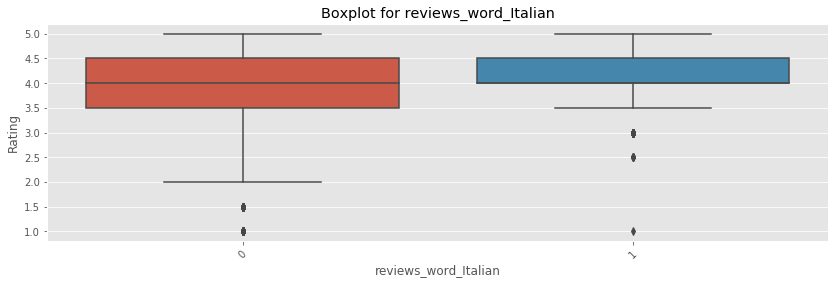

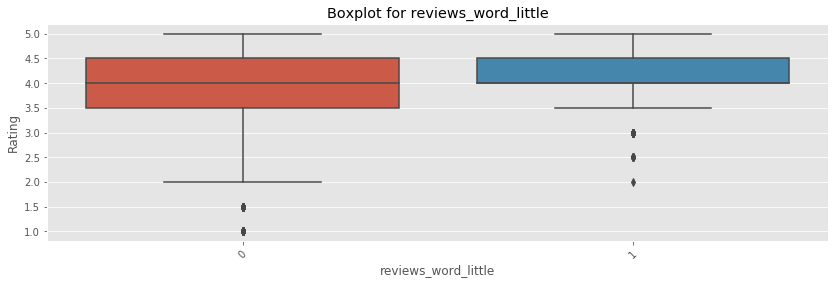

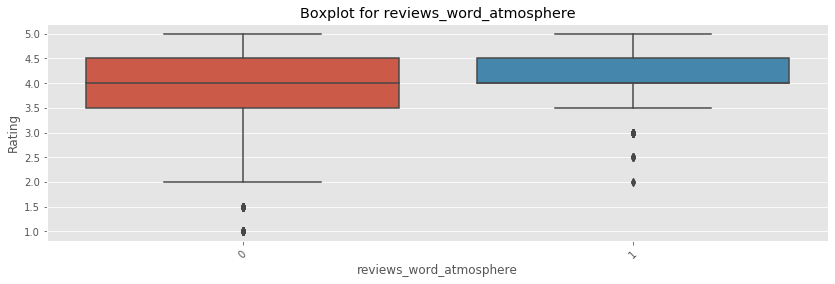

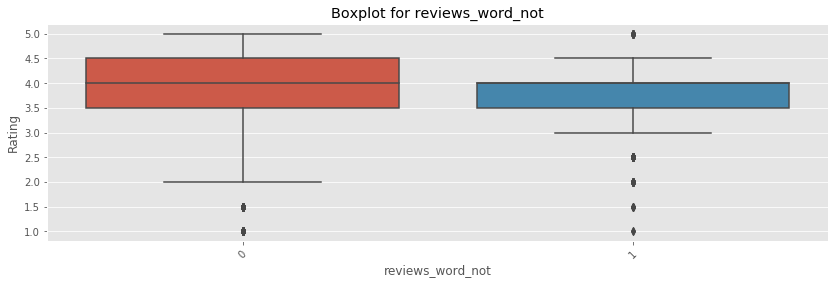

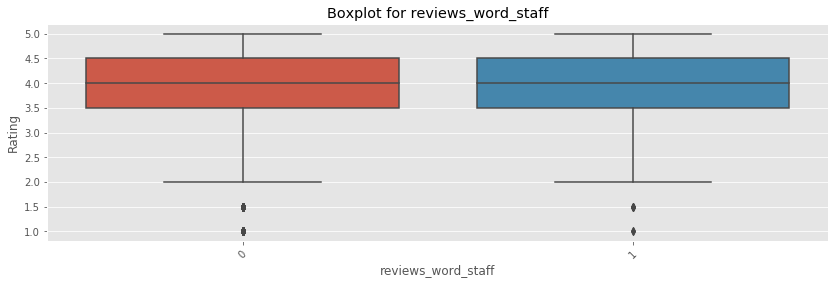

In [48]:
for col in [x for x in data.columns if 'reviews_word' in x]:
    get_boxplot(col)

Например, для слова 'food' (1 - присутствует в отзыве, 0 - нет) значения рейтинга не заметно отличаются: боксплоты фактически одинаковые. А вот присутствие слова 'Great' в отзыве поднимает минимальный рейтинг с 2 до 3.5.

In [49]:
# выборочно по боксплотам удаляю слова из dummy
for word in ['food', 'in', 'good', 'the', 'for', 'Nice', 'service',
             'to', 'of', 'with', 'nice', 'lunch', 'Food', 'very', 'pizza',
             'staff']:
    data.drop('reviews_word_' + word, axis=1, inplace=True)

In [50]:
# пустые строки в 'Reviews' заменяю нулями

mask = dates.apply(lambda x: len(x) == 0)
empty_idx = data['Reviews'][mask].index.tolist()
data.loc[empty_idx, 'Reviews'] = 0

## URL_TA
URL страницы ресторана на TripAdvisor.

In [53]:
print(data['URL_TA'].iloc[0])
print('Уникальных значений:{}'.format(data['URL_TA'].nunique()))

/Restaurant_Review-g187147-d1912643-Reviews-R_Yves-Paris_Ile_de_France.html
Уникальных значений:39980


## ID_TA
Идентификатор ресторана в базе данных TripAdvisor.

In [54]:
print(data['ID_TA'].iloc[0])
print('Уникальных значений:{}'.format(data['ID_TA'].nunique()))

d1912643
Уникальных значений:39980


In [55]:
# подозрение на почти дублирующиеся строки

display(data[data.ID_TA == 'd3685055']) # пример: всё одинаково, кроме признаков 'Ranking', 'Restaurant_id'
subset_cols = [col for col in data.columns.tolist()
               if col not in ('Ranking', 'Restaurant_id')] 
data.drop_duplicates(subset=subset_cols, inplace=True) # удалить дубли, игнорируя признаки 'Ranking', 'Restaurant_id'

,Restaurant_id,Cuisine Style,Ranking,Rating,Number of Reviews,Reviews,URL_TA,ID_TA,City_Amsterdam,City_Athens,...,reviews_word_best,reviews_word_The,reviews_word_Amazing,reviews_word_at,reviews_word_friendly,reviews_word_Italian,reviews_word_little,reviews_word_atmosphere,reviews_word_not,num_rev_showed
3942,id_5646,"['Lebanese', 'Mediterranean', 'Middle Eastern'...",5649.0,3.5,443.0,"[['Good Lebanese food', 'Decent place'], ['07/...",/Restaurant_Review-g187514-d3685055-Reviews-Sh...,d3685055,0,0,...,0,0,0,0,0,0,0,0,0,1
27680,id_5617,"['Lebanese', 'Mediterranean', 'Middle Eastern'...",5620.0,3.5,443.0,"[['Good Lebanese food', 'Decent place'], ['07/...",/Restaurant_Review-g187514-d3685055-Reviews-Sh...,d3685055,0,0,...,0,0,0,0,0,0,0,0,0,1


## Feature Engineering
После обработки имеющихся признаков создам парочку новых.

In [56]:
# индикатор сетевой/несетевой ресторан

rest_id_freq = data['Restaurant_id'].value_counts()


def network_bool(row):

    # если ресторан несетевой -> 0
    # если ресторан сетевой -> 1

    rest_id = row['Restaurant_id']
    freq = rest_id_freq.loc[rest_id]
    if freq == 1:
        return 0
    else:
        return 1

# размер сети, к которой принадлежит ресторан


def network_size(row):

    # по данным 'Restaurant_id' возвращает число ресторанов в сети, к которой относится наблюдение

    rest_id = row['Restaurant_id']
    freq = rest_id_freq.loc[rest_id]
    return freq


data['network_bool'] = data.apply(network_bool, axis=1)
data['network_size'] = data.apply(network_size, axis=1)

In [57]:
# "свежесть" последнего отзыва

def days_from_last_rev(row):
    today = datetime.date.today()
    if row['Reviews'] == 0:  # если нет ни одного отзыва -> -1
        return datetime.timedelta(days=-1)

    elif pd.isnull(row['2ndRevDate']) or row['2ndRevDate'] < row['1stRevDate']:
        return today - row['1stRevDate'].date()

    elif row['2ndRevDate'] >= row['1stRevDate']:
        return today - row['2ndRevDate'].date()


data['days_from_last_rev'] = data.apply(days_from_last_rev, axis=1).dt.days

# сколько прошло дней между двумя отзывами


def days_between_rev(row):
    # отзывов нет вообще или только один -> -1
    if row['Reviews'] == 0 or pd.isnull(row['2ndRevDate']):
        return datetime.timedelta(-1)
    else:
        return abs(row['2ndRevDate'].date() - row['1stRevDate'].date())


data['days_between_rev'] = data.apply(days_between_rev, axis=1).dt.days

## Матрица корреляций

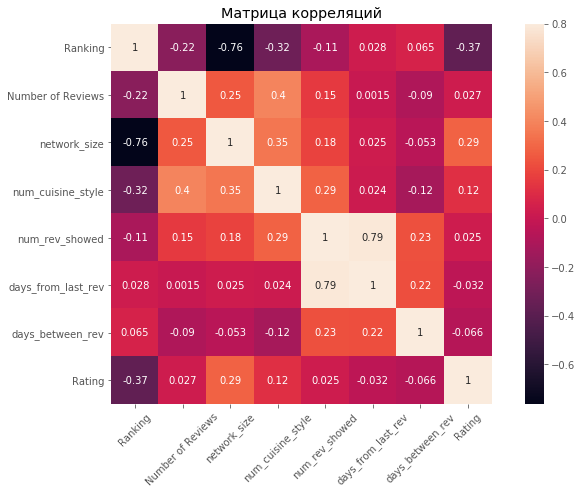

In [76]:
corrmat = data[['Ranking', 'Number of Reviews', 'network_size', 'num_cuisine_style', 'num_rev_showed',
                'days_from_last_rev', 'days_between_rev', 'Rating']].corr()
f, ax = plt.subplots(figsize=(12, 7))
chart = sns.heatmap(corrmat, vmax=.8, square=True, annot=True)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
bottom, top = chart.get_ylim()
plt.title('Матрица корреляций')
ax.set_ylim(bottom + 0.5, top - 0.5);

Признаки 'Ranking', 'network_size', 'num_cuisine_style', 'Ranking' сильнее всего коррелируют с целевой переменной 'Rating'. 

## Выводы по EDA
* Изначально датасет хорошо подготовлен: выбросов и ошибок я не нашла. Пришлось удалить несколько дублей (20 строк при размере датасета 40К строк - не страшно).
* Пропуски в 'Number of Reviews' заменила медианой, в 'Price Range' и 'Cuisine Style' выделила отдельную категорию "не определено". В Reviews нашлись скрытые пропуски (пустые строки вместо NaN).
* В датасете много категориальных переменных, здесь шла двумя путями: полная замена на dummy-переменные, если категорий немного ('Price Range', 'City') или частичная замена на dummy-переменные для 20-30 наиболее часто встречающихся категорий ('Cuisine Style', 'reviews_word_(...)').
* Новые признаки:\
1) число категорий к которым относится наблюдение по определённому признаку ('num_cuisine_style', 'num_rev_showed')\
2) индикатор сетевого/несетевого ресторана ('network_bool') и размер сети, к которой пренадлежит ресторан ('network_size')\
3) сколько прошло дней после последнего отзыва ('days_from_last_rev'), сколько прошло дней между двумя отзывами, отображающимися на странице ('days_between_rev')

## Что улучшить?
Здесь пара слов о сложностях, с которыми я столкнулась.
* Недостаток навыков для более продвинутого анализа текста в отзывах. Предполагаю, что разделение отзывов по эмоциональному оттенку хотя бы на две категории (доволен\недоволен), может существенно улучшить точность модели.
* В датасете есть адреса страниц ресторанов на Tripadvisor. Можно было бы выгрузить дополнительную информацию с того же Tripadvisor по каждому ресторану (например, время работы, адрес и более конкретные оценки посетителей по категориям). Не знаю, как это сделать не вручную.
* Не уверена в организации ноутбука. Удобна ли такая структура для презентации?

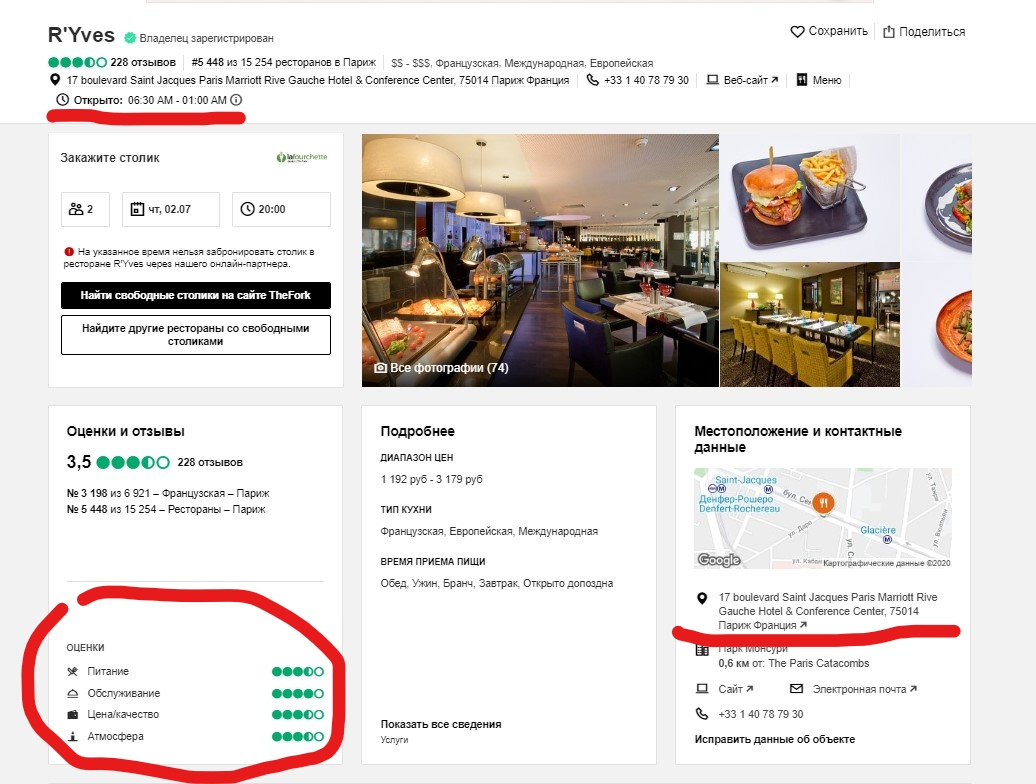

In [60]:
# скрин по потенциально полезной инфе с Tripadvisor
PATH = "D:/Документы/Skillfactory/"
Image(filename=PATH + "tripadv1.jpg", width=750, height=750)

## Предсказание рейтинга алгоритмом случайного леса
Достаю магический шар

In [66]:
X = data.drop(['Restaurant_id', 'Cuisine Style', 'Rating', 'Reviews',
               'URL_TA', 'ID_TA', '1stRevDate', '2ndRevDate'], axis=1)

y = data['Rating']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [68]:
X.info()  # последний взгляд на признаки, с которыми работает алгоритм

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39980 entries, 0 to 39999
Data columns (total 89 columns):
Ranking                      39980 non-null float64
Number of Reviews            39980 non-null float64
City_Amsterdam               39980 non-null uint8
City_Athens                  39980 non-null uint8
City_Barcelona               39980 non-null uint8
City_Berlin                  39980 non-null uint8
City_Bratislava              39980 non-null uint8
City_Brussels                39980 non-null uint8
City_Budapest                39980 non-null uint8
City_Copenhagen              39980 non-null uint8
City_Dublin                  39980 non-null uint8
City_Edinburgh               39980 non-null uint8
City_Geneva                  39980 non-null uint8
City_Hamburg                 39980 non-null uint8
City_Helsinki                39980 non-null uint8
City_Krakow                  39980 non-null uint8
City_Lisbon                  39980 non-null uint8
City_Ljubljana               39980 no

In [69]:
regr = RandomForestRegressor(n_estimators=100)
regr.fit(X_train, y_train)  # обучение
y_pred = regr.predict(X_test)  # предсказание

Чтобы оценить результат использую метрику среднего абсолютного отклонения (mean absolute error):
$$MAE=\frac{\sum_{i=1}^n |a(x_i)-y_i|}{n}$$

- Штрафует линейно, то есть вне зависимости от величины ошибки в среднем "весят" одинаково
- Удобна с точки зрения интрепретации: имеет нужную размерность и однозначный смысл средней ошибки в предсказании
- Имеет недостаток с математической точки зрения, так как предполагает взятие модуля (проблемы с дифференцированием), однако пока это не мешает


In [83]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21375137568784394


In [72]:
y_pred

array([3.975, 3.89 , 4.215, ..., 4.305, 3.595, 4.595])

Алгоритм сработал с точностью 0.21. Можно попытаться улучшить результат (уменьшить среднюю ошибку), использовав ограничение на то, что переменная 'Rating' является дискретной величиной (принимает только целые и полуцелые значения). Для каждого наблюдения округление либо сведёт ошибку в ноль, либо сильно её увеличит. Есть шанс, что в большинстве случаев ошибка убьётся. Ниже код с правилами округления.

In [84]:
y_pred_round = np.copy(y_pred)
for i in range(len(y_pred_round)):
    frac, intg = math.modf(y_pred_round[i])
    if frac < 0.25:
        y_pred_round[i] = intg
    elif frac >= 0.25 and frac < 0.75:
        y_pred_round[i] = intg + 0.5
    elif frac >= 0.75:
        y_pred_round[i] = intg + 1
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_round))

MAE: 0.18034017008504252


Класс!! Округление прилично уменьшило среднюю ошибку. То есть теперь умеем предсказывать рейтинг ресторана с точностью примерно 0.18 балла.

Смысл MAE можно представить геометрически. На плоскости с точками, имеющими координаты $(x, y)$, где $x$ - истинное значение, $y$ - предсказанное моделью, и прямой $y=x$ (точки лежащие на этой прямой - это точно предсказанная целевая переменная), $MAE$ - это среднее расстояние по вертикали от каждой точки до прямой. 

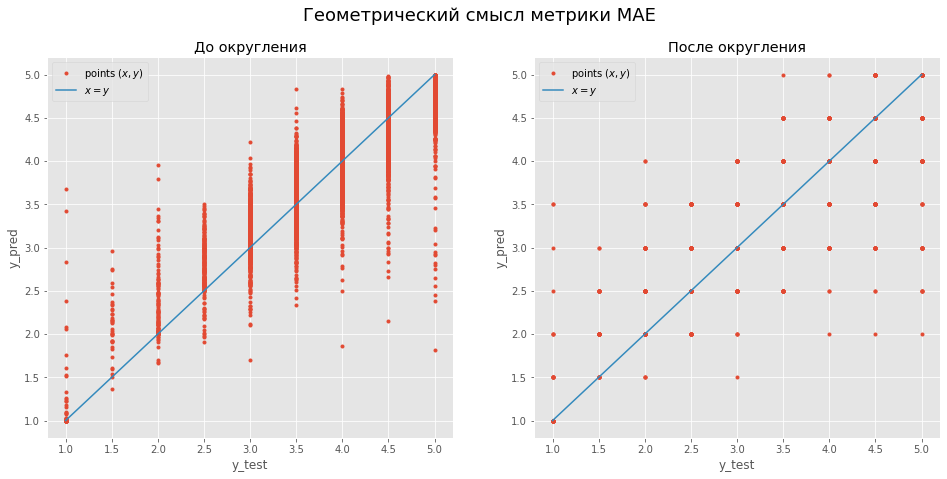

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].plot(y_test, y_pred, '.', label='points $(x, y)$')
ax[0].set_title('До округления')
ax[0].set_xlabel('y_test')
ax[0].set_ylabel('y_pred')
z = np.linspace(1, 5, 100)
ax[0].plot(z, z, label='$x=y$')
ax[0].legend()

ax[1].plot(y_test, y_pred_round, '.', label='points $(x, y)$')
ax[1].plot(z, z, label='$x=y$')
ax[1].set_xlabel('y_test')
ax[1].set_ylabel('y_pred')
ax[1].set_title('После округления')
ax[1].legend()

fig.suptitle('Геометрический смысл метрики MAE', fontsize=18);

## Выводы по построению модели
После предобработки датасета алгоритмом случайного леса получилось достичь точности 0.21 по MAE. Дальше помогло использование ограничения на дискретность целевой переменной, которое не учитывал алгоритм. Итогом умеем предсказывать рейтинг ресторана  точностью 0.18 балла.
## Трудности
* Не могу быть уверена, что выбранный набор признаков в модели даёт *лучший* результат по метрике. Хочется уметь системно перепробовать максимальное количество комбинаций имеющихся признаков, чтобы найти, когда ошибка *минимизируется*. 
* Есть недопонимание теории, которая говорит избавляться от слабокоррелирующих с целевой переменной признаков (см. матрицу корреляций выше). Попытки это сделать увеличивали среднюю ошибку на 0.3 - 0.7 балла. Здесь же отмечу, что в итоге оставила сильно скоррелированные между собой признаки 'network_size' и 'Ranking', так как это улучшает результат по метрике на ~0.1 балл.